In [ ]:
# code from https://github.com/CERN/TIGRE/blob/master/Python/example.py

In [11]:
from __future__ import division
from __future__ import print_function

import numpy as np
import tigre
import tigre.algorithms as algs
from tigre.utilities import sample_loader
from tigre.utilities.Measure_Quality import Measure_Quality
import tigre.utilities.gpu as gpu
import matplotlib.pyplot as plt
import os
from PIL import Image

In [2]:
# 1) Showing available GPUs
listGpuNames = gpu.getGpuNames()
if len(listGpuNames) == 0:
    print("Error: No gpu found")
else:
    for id in range(len(listGpuNames)):
        print("{}: {}".format(id, listGpuNames[id]))

gpuids = gpu.getGpuIds(listGpuNames[0])
#print(gpuids)


0: NVIDIA GeForce RTX 4090
1: NVIDIA GeForce RTX 4090


In [23]:
# 2) Geometry
geo = tigre.geometry(mode="parallel", 
                     nVoxel=np.array([256, 256, 256]),
                     default=True)
geo.dDetector = np.array([0.8, 0.8]) * 2 # size of each pixel in mm
geo.sDetector = geo.dDetector * geo.nDetector

print(geo)


TIGRE parameters
-----
Geometry parameters
Distance from source to detector (DSD) = 512.0 mm
Distance from source to origin (DSO)= 256.0 mm
-----
Detector parameters
Number of pixels (nDetector) = [256 256]
Size of each pixel (dDetector) = [1.6 1.6] mm
Total size of the detector (sDetector) = [409.6 409.6] mm
-----
Image parameters
Number of voxels (nVoxel) = [256 256 256]
Total size of the image (sVoxel) = [256 256 256] mm
Size of each voxel (dVoxel) = [1 1 1] mm
-----
Offset correction parameters
Offset of image from origin (offOrigin) = [0 0 0] mm
Offset of detector (offDetector) = [0 0] mm
-----
Auxillary parameters
Samples per pixel of forward projection (accuracy) = 0.5
-----
Rotation of the Detector (rotDetector) = [0 0 0] rad


In [4]:
# 3) Prepare angles
nangles = 128
angles = np.linspace(0, 2 * np.pi, nangles, endpoint=False, dtype=np.float32)
print(len(angles))

128


In [8]:
# 4) prepare projection data
head = sample_loader.load_head_phantom(geo.nVoxel)
projections = tigre.Ax(head, geo, angles, gpuids=gpuids)
gt_volume = tigre.Atb(proj, geo, angles, backprojection_type="matched", gpuids=gpuids)

print(type(proj), projections.shape, gt_volume.shape)
#np.save('volume.npy', test)

<class 'numpy.ndarray'> (128, 256, 256) (256, 256, 256)


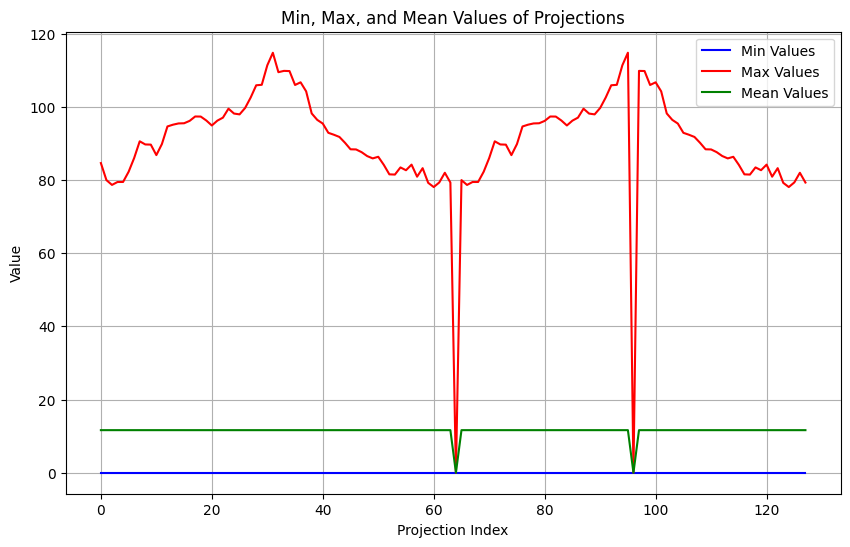

In [9]:
mins = projections.min(axis=(1, 2))
maxs = projections.max(axis=(1, 2))
means = projections.mean(axis=(1, 2))

plt.figure(figsize=(10, 6))
plt.plot(mins, label='Min Values', color='blue')
plt.plot(maxs, label='Max Values', color='red')
plt.plot(means, label='Mean Values', color='green')
plt.xlabel('Projection Index')
plt.ylabel('Value')
plt.title('Min, Max, and Mean Values of Projections')
plt.legend()
plt.grid()
plt.show()

In [12]:
output_folder = "."
for i, projection in enumerate(projections):
    projection_normalized = ((projection - projection.min()) / (projection.ptp()) * 255).astype(np.uint8)
    img = Image.fromarray(projection_normalized)
    img.save(os.path.join(output_folder, f"projection_{i:04d}.png"))
print('Projections saved')

Projections saved


/tmp/ipykernel_15469/2946533757.py:3: RuntimeWarning: invalid value encountered in divide
  projection_normalized = ((projection - projection.min()) / (projection.ptp()) * 255).astype(np.uint8)


In [14]:
# Reconstruct with FDK (<1 sec)
fdkout = algs.fdk(projections, geo, angles, gpuids=gpuids)
np.save('fdk_volume.npy', fdkout)

In [17]:
# Reconstruct with OSSART
niter = 20
ossart = algs.ossart(proj, geo, angles, niter, blocksize=20, gpuids=gpuids)
np.save('ossart_volume.npy', fdkout)

OSSART algorithm in progress.
Estimated time until completion : 00:00:18


In [18]:
# Measure Quality
# 'RMSE', 'MSSIM', 'SSD', 'UQI'
print("RMSE fdk:")
print(Measure_Quality(fdkout, head, ["nRMSE"]))
print("RMSE ossart")
print(Measure_Quality(ossart, head, ["nRMSE"]))

RMSE fdk:
3298.880884490056
RMSE ossart
254.35261165273977


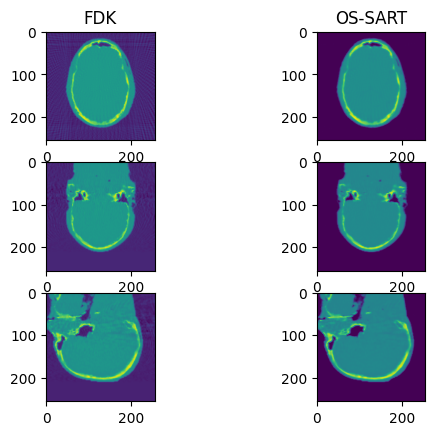

In [19]:
fig, axes = plt.subplots(3, 2)
axes[0, 0].set_title("FDK")
axes[0, 0].imshow(fdkout[geo.nVoxel[0] // 2])
axes[1, 0].imshow(fdkout[:, geo.nVoxel[1] // 2, :])
axes[2, 0].imshow(fdkout[:, :, geo.nVoxel[2] // 2])
axes[0, 1].set_title("OS-SART")
axes[0, 1].imshow(ossart[geo.nVoxel[0] // 2])
axes[1, 1].imshow(ossart[:, geo.nVoxel[1] // 2, :])
axes[2, 1].imshow(ossart[:, :, geo.nVoxel[2] // 2])
plt.show()

In [22]:
#tigre.plotProj(projections)
tigre.plotImg(fdkout)

<Figure size 640x480 with 0 Axes>